In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())

Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%        1.000000           -0.901371           

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        Root10DaysSeedling  Leaf45DaysOldPlant  Shoot10DaysSeedling  \
count        41110.000000        41110.000000         41110.000000   
mean            -0.522040           -0.585144            -0.545055   
std              0.498568            0.399046             0.477438   
min             -1.000000           -1.000000            -1.000000   
25%             -0.901371           -0.901444            -0.906055   
50%             -0.663664           -0.643376            -0.698864   
75%             -0.378497           -0.451900            -0.250588   
max              1.000000            1.000000             1.000000   

       Shoot35DaysSeedling  Root35DaysSeedling  Leaf21DaysSeedling  \
count         41110.000000        41110.000000        41110.000000   
mean             -0.558906           -0.596196           -0.828778   
std               0.506423            0.461679            0.327542   
min              -1.000000 

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

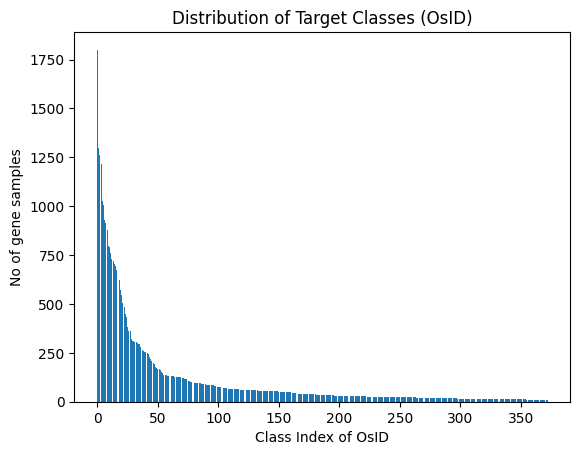

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=40, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Number of input features: 1
Fold: 1
Epoch 1/40
1846/1846 [==============================] - 5s 2ms/step - loss: 4.3508 - accuracy: 0.1139 - val_loss: 3.9500 - val_accuracy: 0.1778
Epoch 2/40
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6223 - accuracy: 0.2063 - val_loss: 3.5462 - val_accuracy: 0.2367
Epoch 3/40
1846/1846 [==============================] - 3s 2ms/step - loss: 3.2654 - accuracy: 0.2621 - val_loss: 3.2614 - val_accuracy: 0.2937
Epoch 4/40
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9896 - accuracy: 0.2974 - val_loss: 3.0512 - val_accuracy: 0.2942
Epoch 5/40
1846/1846 [==============================] - 3s 1ms/step - loss: 2.7921 - accuracy: 0.3292 - val_loss: 2.8675 - val_accuracy: 0.3270
Epoch 6/40
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6497 - accuracy: 0.3519 - val_loss: 2.7447 - val_accuracy: 0.3540
Epoch 7/40
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5377 - accuracy: 0.369

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 14s 6ms/step - loss: 4.2204 - accuracy: 0.1663 - val_loss: 3.5564 - val_accuracy: 0.2966
Epoch 2/40
1846/1846 [==============================] - 10s 6ms/step - loss: 2.9250 - accuracy: 0.3859 - val_loss: 2.6973 - val_accuracy: 0.4625
Epoch 3/40
1846/1846 [==============================] - 10s 5ms/step - loss: 2.1608 - accuracy: 0.5158 - val_loss: 2.1310 - val_accuracy: 0.5272
Epoch 4/40
1846/1846 [==============================] - 10s 6ms/step - loss: 1.6973 - accuracy: 0.5860 - val_loss: 1.8444 - val_accuracy: 0.6114
Epoch 5/40
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4421 - accuracy: 0.6380 - val_loss: 1.6303 - val_accuracy: 0.6627
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2796 - accuracy: 0.6715 - val_loss: 1.5341 - val_accuracy: 0.6686
Epoch 7/40
1846/1846 [==============================] - 9s 5ms/step - loss: 1.1706 - accuracy: 0.6915 - val_loss: 1.3702 - val_accur

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 6ms/step - loss: 3.9418 - accuracy: 0.2481 - val_loss: 3.0771 - val_accuracy: 0.4323
Epoch 2/40
1846/1846 [==============================] - 10s 6ms/step - loss: 2.3514 - accuracy: 0.5435 - val_loss: 2.0738 - val_accuracy: 0.5903
Epoch 3/40
1846/1846 [==============================] - 10s 5ms/step - loss: 1.5663 - accuracy: 0.6615 - val_loss: 1.5873 - val_accuracy: 0.6616
Epoch 4/40
1846/1846 [==============================] - 8s 4ms/step - loss: 1.1557 - accuracy: 0.7246 - val_loss: 1.2518 - val_accuracy: 0.7639
Epoch 5/40
1846/1846 [==============================] - 10s 6ms/step - loss: 0.9304 - accuracy: 0.7661 - val_loss: 1.1241 - val_accuracy: 0.7553
Epoch 6/40
1846/1846 [==============================] - 10s 5ms/step - loss: 0.8059 - accuracy: 0.7918 - val_loss: 0.9740 - val_accuracy: 0.8007
Epoch 7/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.7154 - accuracy: 0.8110 - val_loss: 0.9137 - val_acc

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 6ms/step - loss: 3.6316 - accuracy: 0.3175 - val_loss: 2.5917 - val_accuracy: 0.5424
Epoch 2/40
1846/1846 [==============================] - 11s 6ms/step - loss: 1.8464 - accuracy: 0.6543 - val_loss: 1.7849 - val_accuracy: 0.7045
Epoch 3/40
1846/1846 [==============================] - 11s 6ms/step - loss: 1.1563 - accuracy: 0.7647 - val_loss: 1.2744 - val_accuracy: 0.7714
Epoch 4/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.8351 - accuracy: 0.8160 - val_loss: 0.9919 - val_accuracy: 0.8152
Epoch 5/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.6650 - accuracy: 0.8431 - val_loss: 0.8573 - val_accuracy: 0.8332
Epoch 6/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.5715 - accuracy: 0.8586 - val_loss: 0.7759 - val_accuracy: 0.8590
Epoch 7/40
1846/1846 [==============================] - 10s 5ms/step - loss: 0.5113 - accuracy: 0.8684 - val_loss: 0.7073 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 3.5496 - accuracy: 0.3386 - val_loss: 2.3777 - val_accuracy: 0.5802
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6102 - accuracy: 0.6954 - val_loss: 1.3585 - val_accuracy: 0.7481
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.9198 - accuracy: 0.8097 - val_loss: 1.2013 - val_accuracy: 0.7930
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.6350 - accuracy: 0.8552 - val_loss: 0.8217 - val_accuracy: 0.8486
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4973 - accuracy: 0.8806 - val_loss: 0.6994 - val_accuracy: 0.8647
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4222 - accuracy: 0.8939 - val_loss: 0.6137 - val_accuracy: 0.8728
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3762 - accuracy: 0.9030 - val_loss: 0.5388 - val_accuracy: 0.8990
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.6881 - accuracy: 0.3322 - val_loss: 2.5620 - val_accuracy: 0.5842
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7325 - accuracy: 0.6960 - val_loss: 1.4817 - val_accuracy: 0.7408
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.9597 - accuracy: 0.8072 - val_loss: 0.9861 - val_accuracy: 0.8108
Epoch 4/40
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6233 - accuracy: 0.8651 - val_loss: 0.7389 - val_accuracy: 0.8739
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4635 - accuracy: 0.8958 - val_loss: 0.6322 - val_accuracy: 0.8911
Epoch 6/40
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3770 - accuracy: 0.9138 - val_loss: 0.5426 - val_accuracy: 0.9215
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3228 - accuracy: 0.9262 - val_loss: 0.5047 - val_accuracy: 0.9256
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.6531 - accuracy: 0.3151 - val_loss: 2.4177 - val_accuracy: 0.5734
Epoch 2/40
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5938 - accuracy: 0.7031 - val_loss: 1.3016 - val_accuracy: 0.7624
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8490 - accuracy: 0.8226 - val_loss: 0.8799 - val_accuracy: 0.8537
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.5366 - accuracy: 0.8762 - val_loss: 0.6766 - val_accuracy: 0.8891
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4062 - accuracy: 0.9010 - val_loss: 0.5670 - val_accuracy: 0.9052
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3384 - accuracy: 0.9176 - val_loss: 0.4964 - val_accuracy: 0.9052
Epoch 7/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2891 - accuracy: 0.9277 - val_loss: 0.4405 - val_accuracy: 0.9250
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 3.4399 - accuracy: 0.3750 - val_loss: 2.1890 - val_accuracy: 0.6587
Epoch 2/40
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4686 - accuracy: 0.7392 - val_loss: 1.3174 - val_accuracy: 0.7822
Epoch 3/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.8592 - accuracy: 0.8282 - val_loss: 0.9611 - val_accuracy: 0.8337
Epoch 4/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5782 - accuracy: 0.8769 - val_loss: 0.7408 - val_accuracy: 0.8592
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4359 - accuracy: 0.9001 - val_loss: 0.6463 - val_accuracy: 0.8766
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3496 - accuracy: 0.9188 - val_loss: 0.5520 - val_accuracy: 0.8986
Epoch 7/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3027 - accuracy: 0.9268 - val_loss: 0.5100 - val_accuracy: 0.9171
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 3.6271 - accuracy: 0.3233 - val_loss: 2.4119 - val_accuracy: 0.6119
Epoch 2/40
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6004 - accuracy: 0.7141 - val_loss: 1.3923 - val_accuracy: 0.7633
Epoch 3/40
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9064 - accuracy: 0.8204 - val_loss: 0.9763 - val_accuracy: 0.8400
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.6149 - accuracy: 0.8664 - val_loss: 0.8066 - val_accuracy: 0.8605
Epoch 5/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4592 - accuracy: 0.8920 - val_loss: 0.6641 - val_accuracy: 0.8920
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3765 - accuracy: 0.9118 - val_loss: 0.5701 - val_accuracy: 0.9138
Epoch 7/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3131 - accuracy: 0.9247 - val_loss: 0.5412 - val_accuracy: 0.9072
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 3.4379 - accuracy: 0.3713 - val_loss: 2.1059 - val_accuracy: 0.6761
Epoch 2/40
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3285 - accuracy: 0.7641 - val_loss: 1.1515 - val_accuracy: 0.8020
Epoch 3/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.7192 - accuracy: 0.8537 - val_loss: 0.8007 - val_accuracy: 0.8548
Epoch 4/40
1846/1846 [==============================] - 5s 2ms/step - loss: 0.4728 - accuracy: 0.8932 - val_loss: 0.6385 - val_accuracy: 0.8849
Epoch 5/40
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3637 - accuracy: 0.9132 - val_loss: 0.5134 - val_accuracy: 0.9144
Epoch 6/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2952 - accuracy: 0.9285 - val_loss: 0.4902 - val_accuracy: 0.9118
Epoch 7/40
1846/1846 [==============================] - 5s 2ms/step - loss: 0.2622 - accuracy: 0.9339 - val_loss: 0.4309 - val_accuracy: 0.9248
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 3.4883 - accuracy: 0.3618 - val_loss: 2.2157 - val_accuracy: 0.6475
Epoch 2/40
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3905 - accuracy: 0.7407 - val_loss: 1.2308 - val_accuracy: 0.8084
Epoch 3/40
1846/1846 [==============================] - 7s 4ms/step - loss: 0.7535 - accuracy: 0.8449 - val_loss: 0.9196 - val_accuracy: 0.8293
Epoch 4/40
1846/1846 [==============================] - 6s 3ms/step - loss: 0.5209 - accuracy: 0.8834 - val_loss: 0.7291 - val_accuracy: 0.8803
Epoch 5/40
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4090 - accuracy: 0.9047 - val_loss: 0.6098 - val_accuracy: 0.9030
Epoch 6/40
1846/1846 [==============================] - 7s 4ms/step - loss: 0.3372 - accuracy: 0.9187 - val_loss: 0.5410 - val_accuracy: 0.9221
Epoch 7/40
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2990 - accuracy: 0.9258 - val_loss: 0.5019 - val_accuracy: 0.9309
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 14s 6ms/step - loss: 3.4783 - accuracy: 0.3660 - val_loss: 2.3768 - val_accuracy: 0.5421
Epoch 2/40
1846/1846 [==============================] - 11s 6ms/step - loss: 1.5414 - accuracy: 0.7072 - val_loss: 1.3054 - val_accuracy: 0.7630
Epoch 3/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.8449 - accuracy: 0.8248 - val_loss: 0.8951 - val_accuracy: 0.8385
Epoch 4/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.5609 - accuracy: 0.8735 - val_loss: 0.6952 - val_accuracy: 0.8871
Epoch 5/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.4212 - accuracy: 0.9008 - val_loss: 0.6176 - val_accuracy: 0.8739
Epoch 6/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3447 - accuracy: 0.9160 - val_loss: 0.5184 - val_accuracy: 0.9131
Epoch 7/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.2903 - accuracy: 0.9276 - val_loss: 0.4887 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 14s 7ms/step - loss: 3.5580 - accuracy: 0.3424 - val_loss: 2.3371 - val_accuracy: 0.6183
Epoch 2/40
1846/1846 [==============================] - 11s 6ms/step - loss: 1.5347 - accuracy: 0.7076 - val_loss: 1.3010 - val_accuracy: 0.7650
Epoch 3/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.8481 - accuracy: 0.8246 - val_loss: 0.9139 - val_accuracy: 0.8251
Epoch 4/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.5658 - accuracy: 0.8729 - val_loss: 0.7056 - val_accuracy: 0.8785
Epoch 5/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.4319 - accuracy: 0.8949 - val_loss: 0.6109 - val_accuracy: 0.9036
Epoch 6/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3577 - accuracy: 0.9134 - val_loss: 0.5760 - val_accuracy: 0.8997
Epoch 7/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3028 - accuracy: 0.9252 - val_loss: 0.5600 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 6ms/step - loss: 3.4744 - accuracy: 0.3759 - val_loss: 2.2526 - val_accuracy: 0.6341
Epoch 2/40
1846/1846 [==============================] - 11s 6ms/step - loss: 1.4608 - accuracy: 0.7276 - val_loss: 1.2536 - val_accuracy: 0.7806
Epoch 3/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.7885 - accuracy: 0.8420 - val_loss: 0.8574 - val_accuracy: 0.8508
Epoch 4/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.5069 - accuracy: 0.8858 - val_loss: 0.6765 - val_accuracy: 0.8812
Epoch 5/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3773 - accuracy: 0.9117 - val_loss: 0.5782 - val_accuracy: 0.9120
Epoch 6/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3144 - accuracy: 0.9229 - val_loss: 0.5074 - val_accuracy: 0.9230
Epoch 7/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.2750 - accuracy: 0.9331 - val_loss: 0.4796 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 6ms/step - loss: 3.3294 - accuracy: 0.3875 - val_loss: 2.0903 - val_accuracy: 0.6264
Epoch 2/40
1846/1846 [==============================] - 11s 6ms/step - loss: 1.3130 - accuracy: 0.7492 - val_loss: 1.1178 - val_accuracy: 0.8033
Epoch 3/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.7122 - accuracy: 0.8437 - val_loss: 0.7651 - val_accuracy: 0.8543
Epoch 4/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.4851 - accuracy: 0.8861 - val_loss: 0.6023 - val_accuracy: 0.8768
Epoch 5/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3756 - accuracy: 0.9077 - val_loss: 0.5203 - val_accuracy: 0.8922
Epoch 6/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3246 - accuracy: 0.9207 - val_loss: 0.4564 - val_accuracy: 0.9243
Epoch 7/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.2813 - accuracy: 0.9297 - val_loss: 0.4612 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 13s 6ms/step - loss: 3.5338 - accuracy: 0.3390 - val_loss: 2.2491 - val_accuracy: 0.5870
Epoch 2/40
1846/1846 [==============================] - 11s 6ms/step - loss: 1.4548 - accuracy: 0.7227 - val_loss: 1.2201 - val_accuracy: 0.7881
Epoch 3/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.7965 - accuracy: 0.8318 - val_loss: 0.8956 - val_accuracy: 0.8317
Epoch 4/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.5383 - accuracy: 0.8765 - val_loss: 0.6679 - val_accuracy: 0.8821
Epoch 5/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.4076 - accuracy: 0.9007 - val_loss: 0.5933 - val_accuracy: 0.8968
Epoch 6/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3414 - accuracy: 0.9138 - val_loss: 0.5596 - val_accuracy: 0.9045
Epoch 7/40
1846/1846 [==============================] - 11s 6ms/step - loss: 0.2948 - accuracy: 0.9259 - val_loss: 0.5834 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 10s 4ms/step - loss: 3.5330 - accuracy: 0.3351 - val_loss: 2.2953 - val_accuracy: 0.5985
Epoch 2/40
1846/1846 [==============================] - 8s 4ms/step - loss: 1.5260 - accuracy: 0.7205 - val_loss: 1.3512 - val_accuracy: 0.7736
Epoch 3/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.8901 - accuracy: 0.8251 - val_loss: 0.9372 - val_accuracy: 0.8484
Epoch 4/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.6079 - accuracy: 0.8682 - val_loss: 0.7879 - val_accuracy: 0.8722
Epoch 5/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.4453 - accuracy: 0.8972 - val_loss: 0.6442 - val_accuracy: 0.8975
Epoch 6/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.3580 - accuracy: 0.9146 - val_loss: 0.5525 - val_accuracy: 0.9164
Epoch 7/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.3008 - accuracy: 0.9284 - val_loss: 0.5352 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 10s 5ms/step - loss: 3.2781 - accuracy: 0.3892 - val_loss: 1.8763 - val_accuracy: 0.6706
Epoch 2/40
1846/1846 [==============================] - 8s 4ms/step - loss: 1.1868 - accuracy: 0.7605 - val_loss: 1.0160 - val_accuracy: 0.8079
Epoch 3/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.6577 - accuracy: 0.8565 - val_loss: 0.6958 - val_accuracy: 0.8658
Epoch 4/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.4508 - accuracy: 0.8946 - val_loss: 0.5745 - val_accuracy: 0.8792
Epoch 5/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.3518 - accuracy: 0.9134 - val_loss: 0.4988 - val_accuracy: 0.9067
Epoch 6/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.2897 - accuracy: 0.9284 - val_loss: 0.4281 - val_accuracy: 0.9208
Epoch 7/40
1846/1846 [==============================] - 8s 4ms/step - loss: 0.2527 - accuracy: 0.9363 - val_loss: 0.3868 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/40
1846/1846 [==============================] - 5s 2ms/step - loss: 3.2019 - accuracy: 0.4171 - val_loss: 1.9785 - val_accuracy: 0.6664
Epoch 2/40
1846/1846 [==============================] - 5s 2ms/step - loss: 1.2928 - accuracy: 0.7658 - val_loss: 1.1272 - val_accuracy: 0.8088
Epoch 3/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.7116 - accuracy: 0.8574 - val_loss: 0.7494 - val_accuracy: 0.8744
Epoch 4/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4504 - accuracy: 0.8989 - val_loss: 0.6243 - val_accuracy: 0.8999
Epoch 5/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3176 - accuracy: 0.9279 - val_loss: 0.4452 - val_accuracy: 0.9344
Epoch 6/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2506 - accuracy: 0.9411 - val_loss: 0.4023 - val_accuracy: 0.9358
Epoch 7/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2117 - accuracy: 0.9471 - val_loss: 0.4551 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.3437 - accuracy: 0.3763 - val_loss: 2.0792 - val_accuracy: 0.5853
Epoch 2/40
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2898 - accuracy: 0.7573 - val_loss: 1.1200 - val_accuracy: 0.8176
Epoch 3/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6889 - accuracy: 0.8588 - val_loss: 0.8340 - val_accuracy: 0.8502
Epoch 4/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4588 - accuracy: 0.8942 - val_loss: 0.6099 - val_accuracy: 0.8900
Epoch 5/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3519 - accuracy: 0.9119 - val_loss: 0.5269 - val_accuracy: 0.9107
Epoch 6/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2860 - accuracy: 0.9288 - val_loss: 0.5083 - val_accuracy: 0.9113
Epoch 7/40
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2544 - accuracy: 0.9343 - val_loss: 0.4174 - val_accuracy: 0.9360
Epo

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

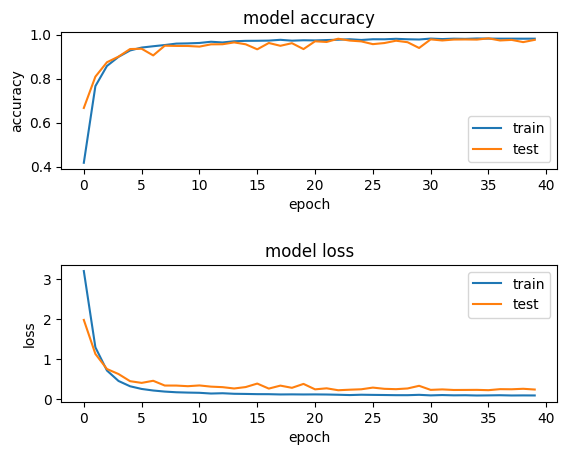

Final Test Accuracy: 0.9845212697982788


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       0.97      1.00      0.99       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         328              328        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True
